# Create and Train Model

In [26]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

import config
from data_loading import load_data_from_dir


# 1 Two Models to Train Each Batch : Wav Features

## 1.1 Load Split Data

### 1.1.1 Load Training Data

In [2]:
train_wav_dirs = [config.TRAIN_WAV_MFCCS, config.TRAIN_AUG_WAV_MFCCS]
#train_lms_dirs = [config.TRAIN_LMS_MFCCS, config.TRAIN_AUG_LMS_MFCCS]

X_train = []
y_train = []

for train_dir in train_wav_dirs:
    for file_name in os.listdir(train_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(train_dir, file_name)
            mfccs = np.load(file_path)
            X_train.append(mfccs)
            label = file_name.split('.npy')[0]
            y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)


In [3]:
X_train.shape, y_train.shape

((1716, 40, 775), (1716,))

### 1.1.2 Load Test Data

In [4]:
test_dirs = [config.TEST_WAV_MFCCS]
#test_dirs = [config.TEST_LMS_MFCCS]

X_test = []
y_test = []

for test_dir in test_dirs:
    for file_name in os.listdir(test_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(test_dir, file_name)
            mfccs = np.load(file_path)
            X_test.append(mfccs)
            label = file_name.split('.npy')[0]
            y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)


In [5]:
X_test.shape, y_test.shape

((394, 40, 775), (394,))

### 1.1.3 Load Validation Data

In [6]:
val_dirs = [config.VAL_WAV_MFCCS]
#val_dirs = [config.VAL_LMS_MFCCS]

X_val = []
y_val = []

for val_dir in val_dirs:
    for file_name in os.listdir(val_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(val_dir, file_name)
            mfccs = np.load(file_path)
            X_val.append(mfccs)
            label = file_name.split('.npy')[0]
            y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)


In [7]:
X_val.shape, y_val.shape

((344, 40, 775), (344,))

Get number of classes from filename for model

In [8]:
filenames, labels = load_data_from_dir(config.WAV_DIR_PATH)

emotion_labels = [filename.split('-')[2] for filename in filenames] # based on filename identifiers https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

num_classes = len(np.unique(emotion_labels))

print("Number of classes (emotions):", num_classes)

Number of classes (emotions): 8


## 1.2 Define Model

In [41]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

wav_model = models.Sequential([
    layers.Input(shape=X_train_reshaped.shape[1:]),
    #layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', name='conv_layer_1'),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu', name='conv_layer_2'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', name='conv_layer_3'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


### 1.2.1 Show Summary of Model

In [42]:
wav_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_layer_1 (Conv2D)           │ (None, 38, 773, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 19, 386, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 17, 384, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 192, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_3 (Conv2D)           │ (None, 6, 190, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 95, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     9,339,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,433,864 (35.99 MB)

 Trainable params: 9,433,864 (35.99 MB)

 Non-trainable params: 0 (0.00 B)

## 1.3 Compile the Model

In [43]:
wav_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 1.3.1 Need to Encode the Labels as they are String Data

In [12]:
emotions = [label.split('-')[2] for label in y_train]

label_encoder = LabelEncoder()
emotions_encoded = label_encoder.fit_transform(emotions)
emotions_encoded = emotions_encoded.reshape(-1, 1)

encoder = OneHotEncoder(categories='auto', sparse_output=False) # try sparse true 
y_train_encoded = encoder.fit_transform(emotions_encoded)

y_test_encoded = encoder.transform(label_encoder.transform([label.split('-')[2] for label in y_test]).reshape(-1, 1))
y_val_encoded = encoder.transform(label_encoder.transform([label.split('-')[2] for label in y_val]).reshape(-1, 1))


In [13]:
print(np.unique(emotions))

['01' '02' '03' '04' '05' '06' '07' '08']


In [37]:
y_train_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## 1.4 Train the Model

In [44]:
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

history = wav_model.fit(X_train_reshaped, y_train_encoded,
                    epochs=10, 
                    batch_size=32,
                    validation_data=(X_val_reshaped, y_val_encoded)) 


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 586ms/step - accuracy: 0.1718 - loss: 6.0655 - val_accuracy: 0.3110 - val_loss: 1.7733
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.3466 - loss: 1.7125 - val_accuracy: 0.3924 - val_loss: 1.6779
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 572ms/step - accuracy: 0.5124 - loss: 1.3994 - val_accuracy: 0.4913 - val_loss: 1.4048
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.5998 - loss: 1.0740 - val_accuracy: 0.5552 - val_loss: 1.1363
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 608ms/step - accuracy: 0.7360 - loss: 0.7780 - val_accuracy: 0.6366 - val_loss: 1.0784
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 596ms/step - accuracy: 0.8082 - loss: 0.5390 - val_accuracy: 0.6831 - val_loss: 1.1131
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 591ms/step - accuracy: 0.8797 - loss: 0.3550 - val_accuracy: 0.6773 - val_loss: 1.2373
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 609ms/step - accuracy: 0.9305 - loss: 0.2300 - val_accu

* dropout : https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
* evaluate: https://medium.com/pydatascience/4-techniques-of-evaluating-the-performance-of-deep-learning-models-using-validation-35ef4b12e8d8
* batch normalisation : https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
* global average poolong: https://medium.com/aaweg-i-nterview/computer-vision-global-average-pooling-d2bbdfbd713f
* regularising : https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7

## 1.5 Evaluate Model

### 1.5.1 Assess Performance

In [45]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

test_loss, test_accuracy = wav_model.evaluate(X_test_reshaped, y_test_encoded)
print('Test accuracy:', test_accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6537 - loss: 1.7823
Test accuracy: 0.6954314708709717


### 1.5.2 Loss & Accuracy Graph

In [46]:
# https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

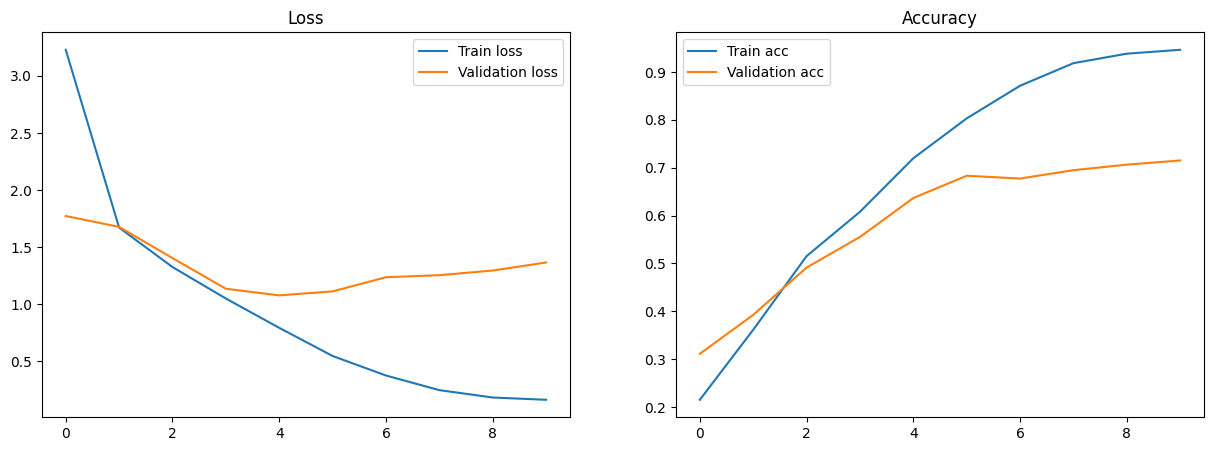

In [47]:
show_final_history(history)

# 2 Two Models to Train Each Batch : LMS Features

## 2.1 Load Split Data

### 2.1.1 Load Training Data

In [ ]:
#train_wav_dirs = [config.TRAIN_WAV_MFCCS, config.TRAIN_AUG_WAV_MFCCS]
train_lms_dirs = [config.TRAIN_LMS_MFCCS, config.TRAIN_AUG_LMS_MFCCS]

X_train = []
y_train = []

for train_dir in train_lms_dirs:
    for file_name in os.listdir(train_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(train_dir, file_name)
            mfccs = np.load(file_path)
            X_train.append(mfccs)
            label = file_name.split('.npy')[0]
            y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train.shape, y_train.shape

### 2.1.2 Load Testing Data

In [ ]:
#test_dirs = [config.TEST_WAV_MFCCS]
test_dirs = [config.TEST_LMS_MFCCS]

X_test = []
y_test = []

for test_dir in test_dirs:
    for file_name in os.listdir(test_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(test_dir, file_name)
            mfccs = np.load(file_path)
            X_test.append(mfccs)
            label = file_name.split('.npy')[0]
            y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_test.shape, y_test.shape

### 2.1.3 Load Validation Data

In [ ]:
#val_dirs = [config.VAL_WAV_MFCCS]
val_dirs = [config.VAL_LMS_MFCCS]

X_val = []
y_val = []

for val_dir in val_dirs:
    for file_name in os.listdir(val_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(val_dir, file_name)
            mfccs = np.load(file_path)
            X_val.append(mfccs)
            label = file_name.split('.npy')[0]
            y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
X_val.shape, y_val.shape

## 2.2 Define Model

In [ ]:
# needs a lot of tweaking for lms features ? See previous list of techniques to prevent overfitting

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

lms_model = models.Sequential([
    layers.Input(shape=X_train_reshaped.shape[1:]),
    #layers.Conv2D(32, (5, 5), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    #layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    #layers.flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
lms_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
emotions = [label.split('-')[2] for label in y_train]

label_encoder = LabelEncoder()
emotions_encoded = label_encoder.fit_transform(emotions)
emotions_encoded = emotions_encoded.reshape(-1, 1)

encoder = OneHotEncoder(categories='auto', sparse_output=False) # try sparse true
y_train_encoded = encoder.fit_transform(emotions_encoded)

y_test_encoded = encoder.transform(label_encoder.transform([label.split('-')[2] for label in y_test]).reshape(-1, 1))
y_val_encoded = encoder.transform(label_encoder.transform([label.split('-')[2] for label in y_val]).reshape(-1, 1))


## 2.3 Train Model

In [ ]:
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

lms_history = lms_model.fit(X_train_reshaped, y_train_encoded,
                    epochs=20, 
                    batch_size=32,
                    validation_data=(X_val_reshaped, y_val_encoded)) 


* the validation data is not too far off, increase epochs. If no change, convergance, tweak model
* incxreased epoch led to dropped val accuracy around 10, suggesting overfitting
 
* evaluation as follows after 10 epichs
 * 7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.3556 - loss: 1.7614
 * Test accuracy: 0.3611111044883728

## 2.4 Evaluate Model

### 2.4.1 Assess Performance

In [ ]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

test_loss, test_accuracy = lms_model.evaluate(X_test_reshaped, y_test_encoded)
print('Test accuracy:', test_accuracy)

### 1.5.2 Loss & Accuracy Graph

In [ ]:
show_final_history(lms_history)